In [7]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import jax.scipy as jsp 
import random
import os
import torch
plt.rc("figure", figsize=[6,6], dpi=150, facecolor='w')
import numpy as np
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return np.random.default_rng(seed)
rng = seed_torch()

In [8]:
@jax.vmap
def TT(s):
    theta = jnp.arctan(s[1]/s[0])
    r = ((s[0]**2 + s[1]**2)**.5)/2
    T = jnp.array([[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]])@jnp.array([[1/r,0],[0,1]])
    return T@T.T

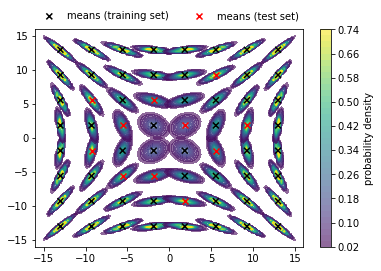

In [9]:

def xy_pairs(nx, ny, span):
    size = nx, ny
    x_grid = jnp.linspace(-span, span, nx)
    y_grid = jnp.linspace(-span, span, ny)
    xx, yy = jnp.meshgrid(x_grid, y_grid)
    return jnp.hstack((xx.reshape(-1,1), yy.reshape(-1,1))), size, xx, yy

val = 16
xy_pairs_eval, grid_size, xx, yy = xy_pairs(100,100, val)
num_means = 8
means, g, xx2, yy2 = xy_pairs(num_means,num_means, 13)
covs = TT(means)

def gaussian_2d_pdf(eval_points, mean, cov):
    return jsp.stats.multivariate_normal.pdf(eval_points, mean=mean, cov=cov)

vmapped_pdf = jax.vmap(gaussian_2d_pdf, in_axes=(None, 0, 0))

# covs = jnp.array([[[1, 0],[3,3]] for _ in means])
pdfs = vmapped_pdf(xy_pairs_eval, means, covs).reshape(len(means), *grid_size) 

fig, ax = plt.subplots()

step = 0.02
m = jnp.amax(pdfs[int(len(pdfs) / 2 - num_means/4)])
levels = jnp.arange(0.0, m, step) + step
for i,pdf in enumerate(pdfs):
    a = ax.contourf(xx, yy, pdf,  alpha=0.6, cmap='viridis',levels=levels)

inner_means = means.reshape(num_means, num_means, 2)[1:-1, 1:-1, :].reshape(-1, 2)
# idxs = rng.choice(len(inner_means), size=int(len(inner_means)/3), replace=False)
test = [[-5.5714287757873535, 1.8571434020996094],
 [1.8571434020996094, -9.285714149475098],
 [-1.8571422100067139, -5.5714287757873535],
 [-1.8571422100067139, 5.57142972946167],
 [1.8571434020996094, 1.8571434020996094],
 [5.57142972946167, -1.8571422100067139],
 [-5.5714287757873535, -5.5714287757873535],
 [-9.285714149475098, 5.57142972946167],
 [5.57142972946167, 9.285715103149414],
 [9.285715103149414, 1.8571434020996094],
 [-9.285714149475098, -1.8571422100067139]]

ax.scatter(xx2, yy2, marker='x', c=['None' if x in test else 'k' for x in means.tolist()], label ="means (training set)")
ax.scatter(np.array(test)[:,0], np.array(test)[:,1], marker='x', c='r', label ="means (test set)")

plt.colorbar(a, ax=ax, label="probability density")
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, frameon=False)
# ax.legend(loc="upper center", fancybox=True,);

In [10]:
from jax.random import multivariate_normal, PRNGKey

train_mask = jnp.array([x not in test for x in means.tolist()])
train_context = means[train_mask]  # making this a variable for use later

@jax.vmap
def samples(mean, cov):
    return multivariate_normal(PRNGKey(0), mean, cov, shape=(10000,))

train_samples = samples(train_context, covs[train_mask])
assert train_samples.shape[0] == len(means) - len(test)

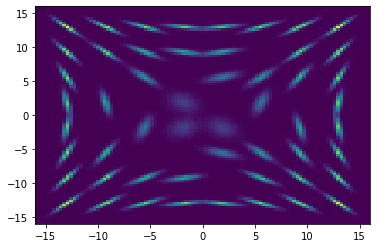

In [11]:
fig, ax = plt.subplots()

bins = np.linspace(-val, val, 100), np.linspace(-val, val, 100)


def plot(ax, s, i):
    x, y = s[:,0], s[:,1]
    ax.hist2d(x,y, density=True, bins=bins)
    ax.set_xlim((-val,val))
    ax.set_ylim((-val,val))

plot(ax, jnp.concatenate(train_samples), 0)
# ax.scatter(xx2, yy2, marker='x', c='r', label ="distribution means")

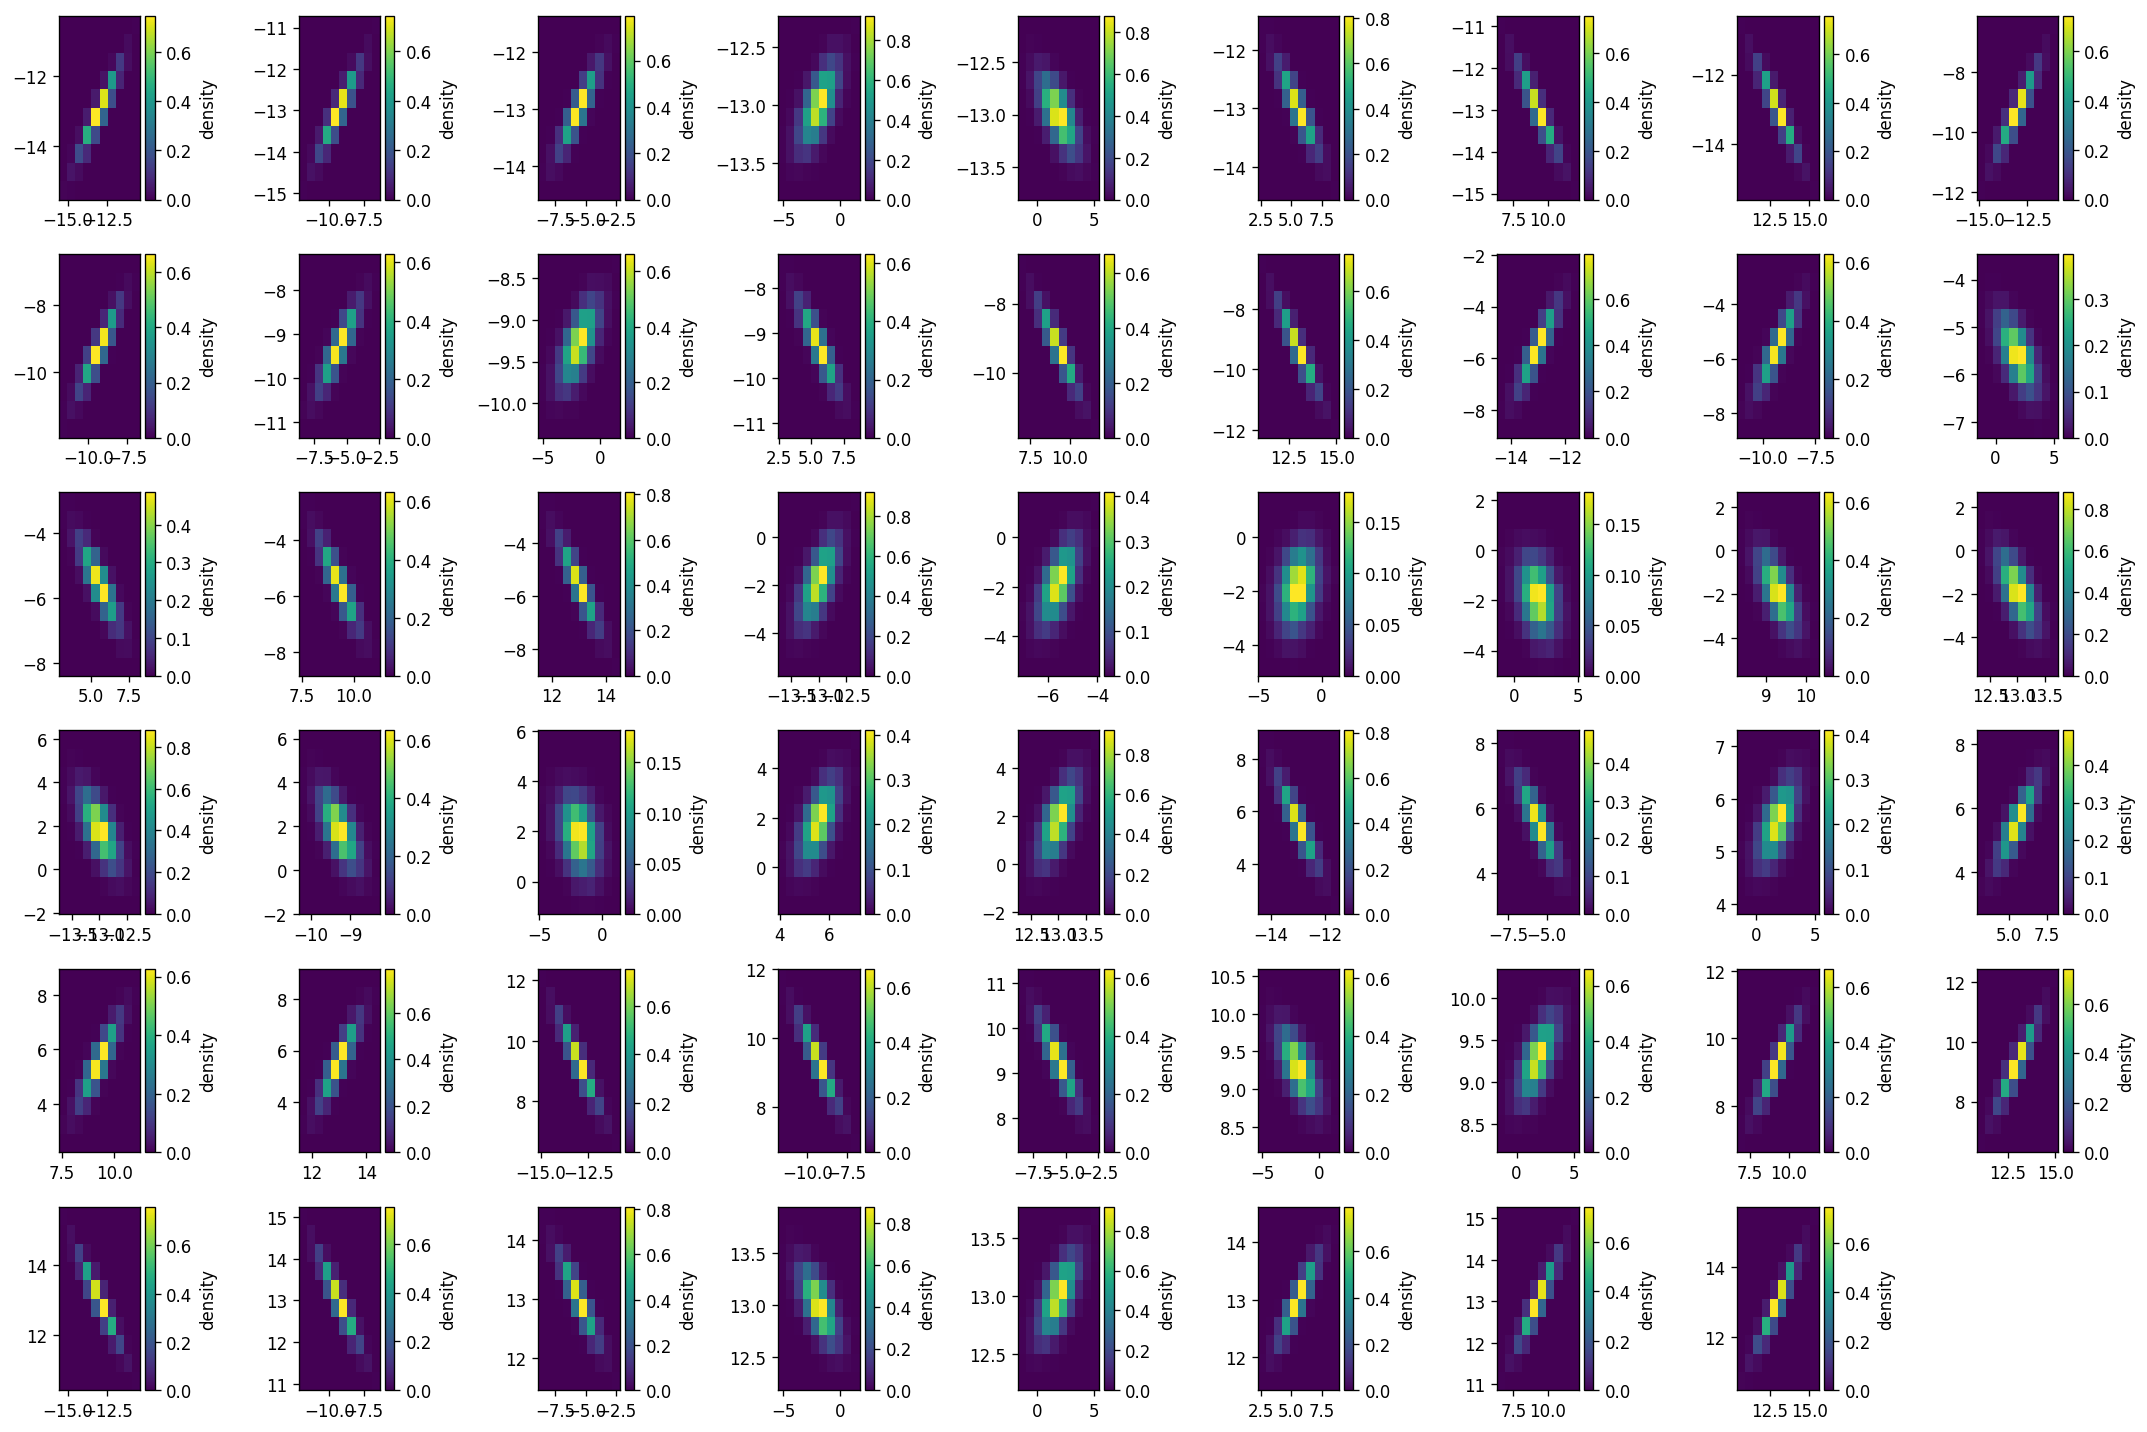

In [12]:
from plothelp import autogrid
from flow_interp import train, sample

train_data_hists, train_x_bins, train_y_bins = sample.make_data_hists2d(train_samples)

def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='viridis')#, norm=colors.LogNorm())
    plt.colorbar(a, ax=ax, label='density')

autogrid(
    list(zip(train_data_hists, train_x_bins, train_y_bins)),
    hist_plot_flow,
);

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

train_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in range(len(train_samples))])

train_concat = np.concatenate(train_samples)
feature_scaler = StandardScaler().fit(train_concat)
context_scaler = MinMaxScaler().fit(train_context_array)

train_all = np.hstack((train_concat, train_context_array))
rng.shuffle(train_all)
train_all.shape

(530000, 4)

In [14]:
def batches(train, batch_size, rng):
    num_train = train.shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism
    def data_stream():
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield train[batch_idx][:, :2], train[batch_idx][:, 2:]  # features, context

    return data_stream()

batch_iter = batches(train_all, 1000, rng)

In [15]:
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation



num_layers=6
hidden_features=4
optimiser=optim.Adam
optimiser_pars=dict(lr=1e-3)

base_dist = ConditionalDiagonalNormal(shape=[2], context_encoder=nn.Linear(2, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(
        MaskedAffineAutoregressiveTransform(
            features=2, hidden_features=hidden_features, context_features=2
        )
    )
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
opt = optimiser(flow.parameters(), **optimiser_pars)

In [37]:
from flow_interp import train

result = train.train_loop(4000, flow, opt, batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)

iteration 0:
train loss = -2.3553757667541504
iteration 100:
train loss = -2.3864023685455322
iteration 200:
train loss = -2.4299840927124023
iteration 300:
train loss = -2.39277720451355
iteration 400:
train loss = -2.43113374710083
iteration 500:
train loss = -2.5146145820617676
iteration 600:
train loss = -2.516918182373047
iteration 700:
train loss = -2.4733400344848633
iteration 800:
train loss = -2.5209085941314697
iteration 900:
train loss = -2.548501968383789
iteration 1000:
train loss = -2.4485976696014404
iteration 1100:
train loss = -2.6006577014923096
iteration 1200:
train loss = -2.532771587371826
iteration 1300:
train loss = -2.577967643737793
iteration 1400:
train loss = -2.508634328842163
iteration 1500:
train loss = -2.5558865070343018
iteration 1600:
train loss = -2.5585267543792725
iteration 1700:
train loss = -2.5666887760162354
iteration 1800:
train loss = -2.6233930587768555
iteration 1900:
train loss = -2.5837385654449463
iteration 2000:
train loss = -2.616837978

/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_38771/2461575254.py:13: RuntimeWarning: divide by zero encountered in divide
  list(zip(abs(flow_hists-test_data_hists)/test_data_hists, test_x_bins, test_y_bins)),
/var/folders/65/tq536_cn3p93dwybgxch05q80000gn/T/ipykernel_38771/2461575254.py:13: RuntimeWarning: invalid value encountered in divide
  list(zip(abs(flow_hists-test_data_hists)/test_data_hists, test_x_bins, test_y_bins)),


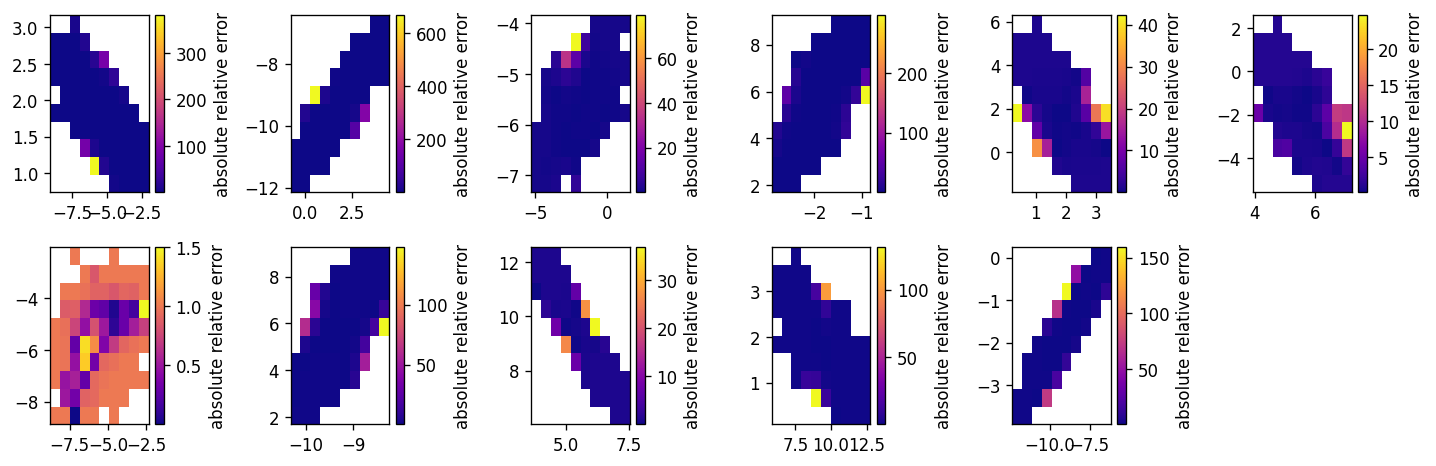

In [41]:
test_samples = samples(jnp.array(test), covs[~train_mask])
assert test_samples.shape[0] == len(test)
test_data_hists, test_x_bins, test_y_bins = sample.make_data_hists2d(test_samples)

flow_hists, _ = sample.hist2d_from_flows_with_error([flow], test_x_bins, test_y_bins, feature_scaler, context_scaler=context_scaler, context=test, num_samples=10000, density=True)
def hist_plot_flow(ax, stuff, i):
    hist, *bins = stuff
    XX, YY = np.meshgrid(bins[0], bins[1])
    a = ax.pcolormesh(XX, YY, (hist.T), shading='flat',cmap='plasma')#, norm=colors.LogNorm())
    plt.colorbar(a, ax=ax, label='absolute relative error')

autogrid(
    list(zip(abs(flow_hists-test_data_hists)/test_data_hists, test_x_bins, test_y_bins)),
    hist_plot_flow,
);

In [49]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

lrs = [1e-2, 5e-2, 1e-3]

for lr in lrs:
    for train_idxs, valid_idxs in kf.split(train_context.tolist()):
        train_points = train_context[train_idxs].tolist()
        valid_points = train_context[valid_idxs].tolist()
        train_fold, valid_fold = np.concatenate(train_samples[train_idxs]), np.concatenate(train_samples[valid_idxs])
        train_fold_context_array = np.concatenate([[train_context[i].tolist()]*len(train_samples[i]) for i in train_idxs])
        assert train_fold.shape == train_fold_context_array.shape
        train_fold_all = np.hstack((train_fold, train_fold_context_array))
        fold_batch_iter = batches(train_fold_all, batch_size=4000, rng=rng)
        flow = Flow(transform, base_dist)
        opt = optimiser(flow.parameters(), lr=lr)    
        _ = train.train_loop(4000, flow, opt, fold_batch_iter, feature_scaler=feature_scaler, context_scaler=context_scaler)
